# Global Overturning Streamfunction

This scipt plots the global overturning streamfunction in density space for 3 ACCESS-OM2 simulations at different resolutions.

It also serves as a sample for how to compute and display diagnostics for the ACCESS-OM2 model evaluation paper.

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/home/157/amh157/.local/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [3]:
cc.start_cluster()

If the link to the dashboard below doesn't work, run this command on a local terminal to set up a SSH tunnel:

  ssh -N -L 37027:127.0.0.1:37027 vdi-n7.nci.org.au -l amh157


Client Scheduler: tcp://127.0.0.1:41912 Dashboard: http://127.0.0.1:37027/status,Cluster Workers: 4 Cores: 8 Memory: 24.00 GB


**For starters**, list the three experiments you want to use. For now, we will use RYF sample runs - in the future we hope to be using the full interannual forcing simulations. This script assumes that there are 3 experiments, and that they are ordered as 1°, 0.25° then 0.1°.

This function computes the overturning from ty_trans_rho. 

**TO DO:** 
* Alter this to compute over a specific date range.
* Avoid use of filesPerYear

In [4]:
def calc_psi_avg(ekey, n=4):
    
    
    expt = exptdata.exptdict[ekey]['expt']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    
    ## Load overturning from ocean.nc file
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None}, n=-n,
                          time_units=time_units, offset=offset)
    psi = psi.mean('time').sum('grid_xt_ocean')*1.0e-9
    
    ## If GM overturning is output, load that too
    varlist = cc.get_variables(expt, 'ocean.nc')
    if 'ty_trans_rho_gm' in varlist:
        GM = True
        psiGM = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho_gm',
                              chunks={'potrho': None}, n=-n,
                              time_units=time_units, offset=offset)
        psiGM = psiGM.mean('time').sum('grid_xt_ocean')*1.0e-9
    else:
        GM = False
        
    psi_avg = psi.cumsum('potrho') -  psi.sum('potrho')
    if GM:
        psi_avg = psi_avg + psiGM
    
    ## This function basically splits the calculation up to save on memory:
    psi_avg = cc.compute_by_block(psi_avg)
    #psi_avg = psi_avg.compute()
    
    return psi_avg

This function plots the streamfunction.

In [5]:
def plot_psi(psi_avg, clev=np.arange(-25,25,2)):

    p1 = plt.contourf(psi_avg.grid_yu_ocean, 
                 psi_avg.potrho, 
                 psi_avg, 
                 cmap=cm.cm.curl,levels=clev,extend='both')
    plt.contour(psi_avg.grid_yu_ocean, 
                psi_avg.potrho, 
                psi_avg, levels=clev, colors='k', linewidths=0.25)
    plt.contour(psi_avg.grid_yu_ocean,
                psi_avg.potrho, psi_avg,
                levels=[0.0,], colors='k', linewidths=0.5)
    plt.gca().invert_yaxis()
    
    plt.ylim((1037.5,1034))
    plt.ylabel('Potential Density (kg m$^{-3}$)')
    plt.xlabel('Latitude ($^\circ$N)')
    plt.xlim([-75,85])
    
    return p1

And here is the code to make the actual figure.

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Deleting cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean.nc_ty_trans_rho_-2_days-since-1718-01-01_-87658_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Deleting cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean.nc_ty_trans_rho_gm_-2_days-since-1718-01-01_-87658_False.pkl


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Deleting cache file cache_get_nc_variable_025deg_jra55v13_iaf_ocean.nc_ty_trans_rho_-10_days-since-1718-01-01_-87658_False.pkl


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-18.04/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


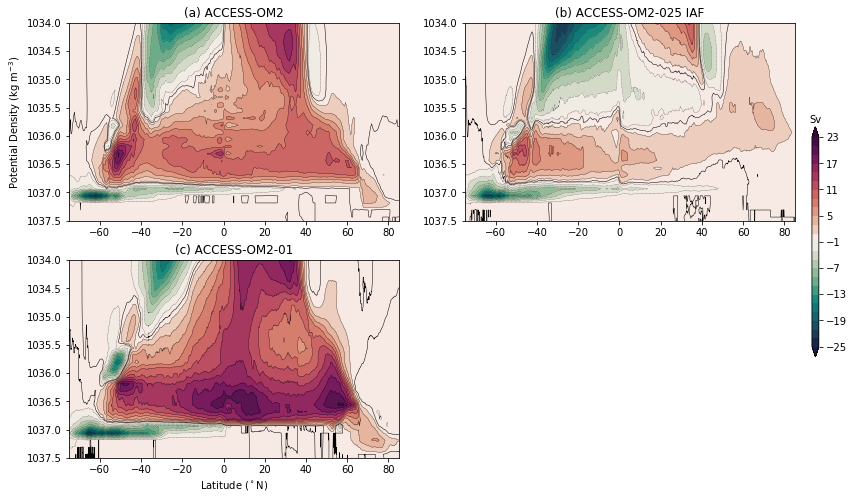

In [6]:
plt.figure(figsize=(12,8))
clev=np.arange(-25,25,2)

n_files = [2, 10, 24]

for i, ekey in enumerate(exptdata.exptdict.keys()):
    plt.subplot(2,2,i+1)
    psi_avg = calc_psi_avg(ekey,n_files[i])
    p1=plot_psi(psi_avg,clev)
    plt.title(exptdata.exptdict[ekey]['desc'])
    
plt.subplot(221)
plt.xlabel('')
plt.title('(a) ACCESS-OM2')
plt.subplot(222)
plt.xlabel('')
plt.ylabel('')
plt.title('(b) ACCESS-OM2-025')
plt.subplot(223)
plt.ylabel('')
plt.title('(c) ACCESS-OM2-01')

plt.subplots_adjust(left=0.08,right=0.92)
ax1 = plt.axes([0.94,0.3,0.008,0.4])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')
ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('Sv')

savefigure('mean_overturning')

### Now compute timeseries of abyssal overturning

1deg_jra55v13_iaf_spinup1_A
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Deleting cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean.nc_ty_trans_rho_None_days-since-1718-01-01_-87658_False.pkl
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Deleting cache file cache_get_nc_variable_1deg_jra55v13_iaf_spinup1_A_ocean.nc_ty_trans_rho_gm_None_days-since-1718-01-01_-87658_False.pkl
025deg_jra55v13_iaf
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Deleting cache file cache_get_nc_variable_025deg_jra55v13_iaf_ocean.nc_ty_trans_rho_None_days-since-1718-01-01_-87658_False.pkl
01deg_jra55v13_iaf
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Deleting cache file cache_get_nc_variable_01deg_jra55v13_iaf_ocean.nc_ty_trans_rho_None_None_None_False.pkl
1deg_jra55v13_iaf_spinup1_A
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


025deg_jra55v13_iaf
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


01deg_jra55v13_iaf
Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db


CPU times: user 4min 57s, sys: 1min 37s, total: 6min 34s
Wall time: 15min 18s


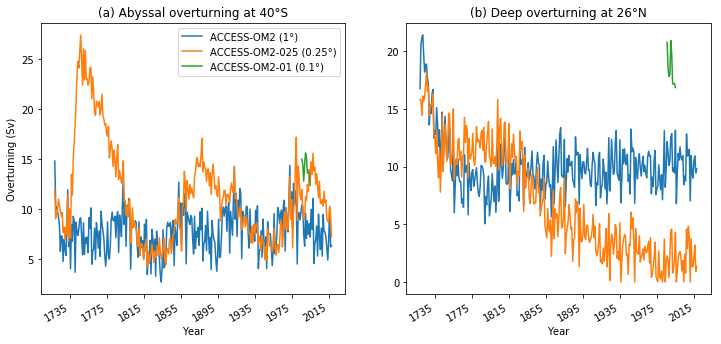

In [7]:
%%time
plt.figure(figsize=(12,5))
plt.subplot(121)
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    n = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    print(expt)
    
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                            chunks={'potrho': None},n=n,
                            time_units = time_units, offset=offset)
    psi = psi.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-40)*1.0e-9
    psi_sum = psi.cumsum('potrho') - psi.sum('potrho')
    
    if ekey == '1deg':
        psiGM = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho_gm',
                            chunks={'potrho': None},n=n,
                            time_units = time_units, offset=offset)
        psiGM = psiGM.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=-40)*1.0e-9
        psi_sum = psi_sum + psiGM

    psi_aabw = -psi_sum.sel(potrho=slice(1036,None))\
                .min('potrho').resample(time='A').mean('time')
    psi_aabw.plot(label=exptdata.exptdict[ekey]['desc'])
    
plt.gca().autoscale()
plt.legend()
plt.ylabel('Overturning (Sv)')
plt.xlabel('Year')
plt.title('(a) Abyssal overturning at 40°S')

plt.subplot(122)
for ekey in exptdata.exptdict.keys():
    expt = exptdata.exptdict[ekey]['expt']
    n = exptdata.exptdict[ekey]['n_files']
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']
    print(expt)
    
    psi = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho',
                          chunks={'potrho': None},n=n,
                          time_units = time_units, offset=offset)
    psi = psi.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
    psi_sum = psi.cumsum('potrho') - psi.sum('potrho')
    
    if ekey == '1deg':
        psiGM = cc.get_nc_variable(expt, 'ocean.nc', 'ty_trans_rho_gm',
                              chunks={'potrho': None},n=n,
                            time_units = time_units, offset=offset)
        psiGM = psiGM.sum('grid_xt_ocean').sel(method='Nearest',grid_yu_ocean=26)*1.0e-9
        psi_sum = psi_sum + psiGM

    psi_amoc = psi_sum.sel(potrho=slice(1035.5,None))\
                .max('potrho').resample(time='A').mean('time')
    psi_amoc.plot(label=exptdata.exptdict[ekey]['desc'])
    
plt.gca().autoscale()
plt.xlabel('Year')
plt.ylabel('')
plt.title('(b) Deep overturning at 26°N')

savefigure('overturning_timeseries')